# Emotion detection using Convolutional Neural Networks with Transfer Learning
## Devansh Srivastav, Akansha Bajpai
Emotion Detection Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img as load
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [2]:
# Importing Dataset

data = pd.read_csv('icml_face_data.csv')

In [3]:
# Checking Dataset Shape

print('Dataset shape:', data.shape)

Dataset shape: (35887, 3)


In [4]:
# Previewing Dataset

data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
# Checking for null values in dataset

print(data.isnull().sum())

emotion    0
 Usage     0
 pixels    0
dtype: int64


In [6]:
# Number of categories for categorical variables

print('Categories for emotions:', set(data['emotion']))
print('Categories for image usage:', set(data[' Usage']))

Categories for emotions: {0, 1, 2, 3, 4, 5, 6}
Categories for image usage: {'Training', 'PublicTest', 'PrivateTest'}


In [7]:
# Dictionary to map numeric values of emotions to corresponding string

emotions_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [8]:
# Saving dictionary

emotions_map = open('emotions_map.json', 'w')
json.dump(emotions_dict, emotions_map)
emotions_map.close()

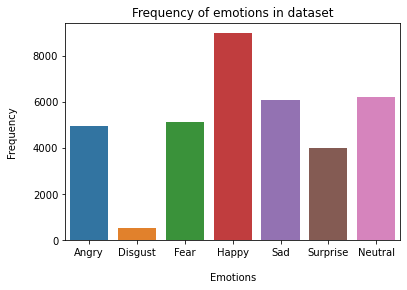

In [9]:
# Visualising the distribution of each emotion in the dataset

sns.countplot(x='emotion', data=data)
plt.title('Frequency of emotions in dataset')
plt.xticks(ticks = [0,1,2,3,4,5,6], labels=list(emotions_dict.values()))
plt.xlabel('\nEmotions')
plt.ylabel('Frequency\n')
plt.show()

In [10]:
# Fetching data from dataframe to get pixels and target value

def load_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 3))
    image_label = np.array(list(map(int, data['emotion'])))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image = Image.fromarray(image)
        image = image.convert("RGB")
        image_array[i] = image
        
    return image_array, image_label

In [11]:
# Train-Test Split

X_train, Y_train = load_data(data[data[' Usage']=='Training'])
X_test, Y_test = load_data(data[data[' Usage']!='Training'])

In [12]:
# Checking the number of training and test samples

print('Number of training samples:', len(X_train))
print('Number of test samples:', len(X_test))

Number of training samples: 28709
Number of test samples: 7178


In [13]:
# Reshaping pixels to dataset's original setting

X_train = X_train.reshape(X_train.shape[0], 48, 48, 3)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 3)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# OnehotEncoding of target variable for softmax activation function

y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)

Visualisation of training images


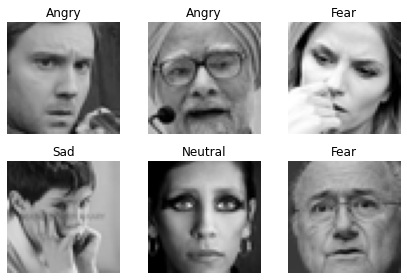

In [14]:
# Visualisation of training images

print('Visualisation of training images')
fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(X_train[i])
    ax.title.set_text(emotions_dict[Y_train[i]])
    ax.axis('off')
plt.tight_layout()
plt.axis('off')
plt.show()

In [15]:
# Image augmentation

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)

datagen.fit(X_train)

In [16]:
# Loading VGG16 as base model for transfer learning

vgg = VGG16(include_top = False, weights = 'imagenet', pooling = 'avg', input_shape = (48,48,3))

In [17]:
# Architecture of VGG 16

vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [18]:
# Pre-processing images as per VGG16 setting

VGG16_image_preprocessing = ImageDataGenerator(preprocessing_function = preprocess_input)
VGG16_image_preprocessing.fit(X_train)
VGG16_image_preprocessing.fit(X_test)

In [19]:
# Additional Layers for classification

model = Sequential()
model.add(vgg)
model.layers[0].trainable = False
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(units = 7, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 14,781,255
Trainable params: 66,567
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# Fitting the model

history = model.fit(X_train, y_train, batch_size=32, epochs=40, verbose=1, validation_data=(X_test, y_test))

Epoch 1/40
898/898 [==============================] - 142s 158ms/step - loss: 0.3587 - accuracy: 0.5506 - val_loss: 0.3434 - val_accuracy: 0.3818
Epoch 2/40
898/898 [==============================] - 154s 171ms/step - loss: 0.3425 - accuracy: 0.5966 - val_loss: 0.3382 - val_accuracy: 0.4042
Epoch 3/40
898/898 [==============================] - 169s 188ms/step - loss: 0.3360 - accuracy: 0.6146 - val_loss: 0.3343 - val_accuracy: 0.4356
Epoch 4/40
898/898 [==============================] - 204s 227ms/step - loss: 0.3310 - accuracy: 0.6256 - val_loss: 0.3224 - val_accuracy: 0.5192
Epoch 5/40
898/898 [==============================] - 194s 216ms/step - loss: 0.3263 - accuracy: 0.6338 - val_loss: 0.3199 - val_accuracy: 0.5225
Epoch 6/40
898/898 [==============================] - 190s 211ms/step - loss: 0.3222 - accuracy: 0.6651 - val_loss: 0.3185 - val_accuracy: 0.5796
Epoch 7/40
898/898 [==============================] - 191s 212ms/step - loss: 0.3183 - accuracy: 0.6549 - val_loss: 0.3091 -

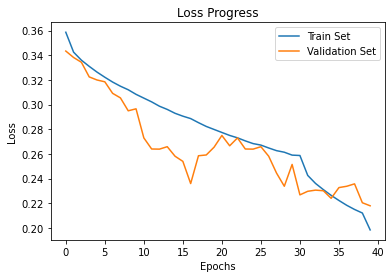

In [21]:
# Visualisation of Model Training (Loss)

plt.plot(list(np.array(history.history['loss'])))
plt.plot(list(np.array(history.history['val_loss'])))
plt.title('Loss Progress')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train Set', 'Validation Set'], loc=1)
plt.show()

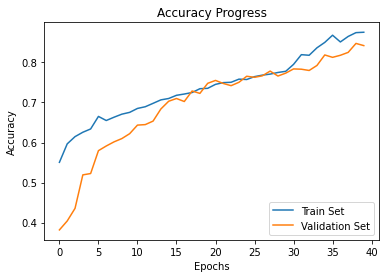

In [22]:
# Visualisation of Model Training (Accuracy)

plt.plot(list(np.array(history.history['accuracy'])))
plt.plot(list(np.array(history.history['val_accuracy'])))
plt.title('Accuracy Progress')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train Set', 'Validation Set'], loc=4)
plt.show()

In [23]:
# Saving the model

model.save('emotion_detection.h5')

In [24]:
# Loading saved model

model = load_model('emotion_detection.h5')

In [25]:
# Loading and preprocessing testing images for prediction

def load_img(image_path):
    test_image = load(image_path, target_size = (48, 48))
    given_image = load(image_path, target_size = (350, 350))                                  
    test_image = img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    return test_image, given_image

In [26]:
# List representing emotions as per their encoded values

emotion_detection = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

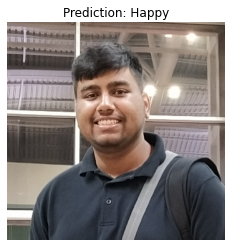

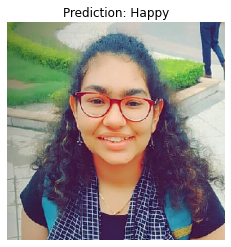

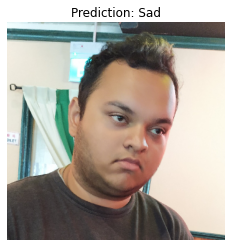

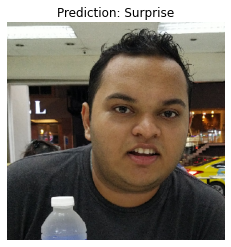

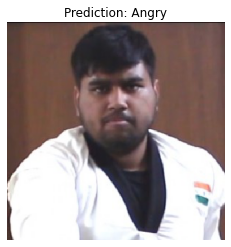

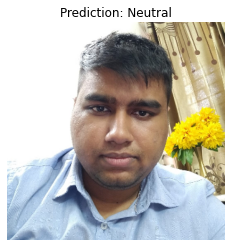

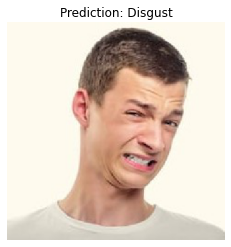

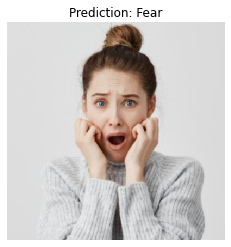

In [27]:
# Testing model

testing_images = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
for img in testing_images:
    test_image, given_image = load_img(img)
    result = model.predict(test_image)
    plt.imshow(given_image)
    plt.title('Prediction: '+emotion_detection[np.argmax(result[0])])
    plt.axis('off')
    plt.show()